In [62]:
import numpy as np
import cvxpy as cp
import scipy
from matplotlib import pyplot as plt

Define the problem matrices

In [63]:
n = 3
m = 2
T = 10

np.random.seed(seed=0)

A  = np.array([[0.88, 0.2, 0.49], [1.12,  0.94, -0.49], [0.48,-0.08, -0.05]])
B  = np.array([[0.28, 0.36], [0.3, 0.27], [0.21, 0.33]])

Q = np.diag(np.random.rand(n))
S = np.diag(np.random.rand(n))
R = np.diag(np.random.rand(m)) + 0.1*np.eye(m)

initial_condition = 10*np.round(np.random.rand(n)-0.5, decimals=2)  # round to prevent numerical instabilities

Solve problem directly using a solve for constrained optimization and compare with closed form solution; one can use sparse matrices for a more efficient implementation.

In [64]:
Q_tilde = scipy.linalg.block_diag(np.kron(np.eye(T-1), Q), S)
R_tilde = np.kron(np.eye(T), R)

# l
l = np.zeros(n*T)
Ax0 = np.matmul(A, initial_condition)
for t in range(T):
  l[t*n:(t+1)*n] = Ax0
  Ax0 = np.matmul(A, Ax0)

# L
L = np.zeros((n*T, m*T))
ApowerB = B
for t in range(T):
  L += np.kron(np.eye(N=T, M=T, k=-t), ApowerB)
  ApowerB = np.matmul(A, ApowerB)

# matrices of the QP
c = np.matmul(np.matmul(initial_condition.T, Q), initial_condition) + np.matmul(np.matmul(l.T, Q_tilde), l)
f = np.matmul(np.matmul(L.T, Q_tilde), l)
F = R_tilde + np.matmul(np.matmul(L.T, Q_tilde), L)
F = 0.5*(F.T + F) # ensure symmetric, even in the presence of numerical errors

# solve as QP (use CVXPY just not to interact with the solver, can call the solve directly)
u = cp.Variable(m*T)
prob = cp.Problem(cp.Minimize(cp.quad_form(u, F) + (2*f.T) @ u + c))

prob.solve(solver=cp.OSQP, verbose=False)

optimal_input_qp = u.value

# analytic
optimal_input_analytic = -np.linalg.solve(F, f)
cost_batch = np.matmul(optimal_input_analytic.T, np.matmul(F, optimal_input_analytic)) + 2.0*np.matmul(f.T, optimal_input_analytic) + c

print('Difference QP - analytic: ' + str(np.mean(np.abs(optimal_input_analytic-optimal_input_qp))))

Difference QP - analytic: 1.877812141892754e-13


We now implement the problem directly used CVXPY.

In [65]:
u = cp.Variable((m, T))
x = cp.Variable((n, T+1))
objective = 0
constraints = [x[:, 0] == initial_condition]
for t in range(T):
    objective += cp.quad_form(x[:, t], Q) + cp.quad_form(u[:, t], R)
    constraints += [x[:, t+1] == A@x[:, t] + B@u[:, t]]
objective += cp.quad_form(x[:,T], S)
prob = cp.Problem(cp.Minimize(objective), constraints)

prob.solve(solver=cp.OSQP, verbose=False)

optimal_input_cvx = u.value.T.reshape(-1)

print('Difference analytic - CVXPY: ' + str(np.mean(np.abs(optimal_input_cvx-optimal_input_analytic))))

print('\nCost batch approach: ' + str(cost_batch))

Difference analytic - CVXPY: 4.8516399231424144e-14

Cost batch approach: 64.54736801086256


Compute LQR controller

In [66]:
def P_new_lqr(P_old: np.ndarray) -> np.ndarray:
  P = Q + \
    np.matmul(np.matmul(A.T, P_old), A) - \
    np.matmul(np.matmul(np.matmul(np.matmul(A.T, P_old), B),
                        np.linalg.inv(R + np.matmul(np.matmul(B.T, P_old), B))),
              np.matmul(B.T, np.matmul(P_old, A)))
  return P

def get_controller_from_P(P: np.ndarray) -> np.ndarray:
  K = - np.matmul(np.linalg.inv(R + np.matmul(np.matmul(B.T, P), B)),
                  np.matmul(B.T, np.matmul(P, A)))
  return K
  
K = []
P = S
for t in range(T): 
  K.append(get_controller_from_P(P).copy())
  P = P_new_lqr(P)

cost_recursive = np.matmul(initial_condition.T, np.matmul(P, initial_condition))

print('Cost recursive approach: ' + str(cost_recursive))

Cost recursive approach: 64.54736801087094


Run simulations


(0.0, 10.0)

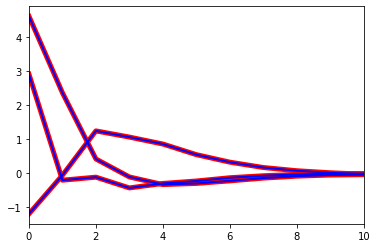

In [67]:
horizon = T

x1 = np.zeros((n, horizon+1))
x2 = np.zeros((n, horizon+1))

x1[:, 0] = initial_condition
x2[:, 0] = initial_condition

noise = False  # set to True to have noise

for t in range(horizon):
  noise_realization = noise*np.random.randn(n)
  x1[:, t+1] = np.matmul(A, x1[:, t]) + np.matmul(B, optimal_input_analytic[t*m:(t+1)*m]) + noise_realization
  x2[:, t+1] = np.matmul(A + np.matmul(B, K[T-1-t]), x2[:, t]) + noise_realization

plt.plot(x1.T, linewidth=5, color='red')
plt.plot(x2.T, linewidth=2, color='blue')
plt.xlim((0, T))

Define the constraints

In [68]:
r = 1 # be careful, problem might become infeasible
p = 1

G = np.round(np.random.randn(r, n), decimals=2)
g = np.round(np.random.randn(r), decimals=2)

H = np.round(np.random.randn(p, m), decimals=2)
h = np.round(np.random.randn(p), decimals=2)

# make sure initial condition  satisfies the constraints
g += (np.matmul(G, initial_condition) - g)

Implement constraints as in b)

In [69]:
# construct matrices
h_tilde = np.kron(np.ones(T), h)
H_tilde = np.kron(np.eye(T), H)
g_tilde = np.kron(np.ones(T), g)
G_tilde = np.kron(np.eye(T), G)

# solve as QP (use CVXPY just not to interact with the solver, can call the solve directly)
u = cp.Variable(m*T)
prob = cp.Problem(cp.Minimize(cp.quad_form(u, F)+ 2.0*(f.T@u) + c),  [G_tilde@L@u <= g_tilde-G_tilde@l, H_tilde@u <= h_tilde]) 

prob.solve(solver=cp.OSQP, verbose=False)

optimal_input_qp_constraints = u.value

Implement constraints in cvxpy

In [70]:
u = cp.Variable((m, T))
x = cp.Variable((n, T+1))
objective = 0
constraints = [x[:, 0] == initial_condition]
for t in range(T):
    objective += cp.quad_form(x[:, t], Q) + cp.quad_form(u[:, t], R)
    constraints += [x[:, t+1] == A@x[:, t] + B@u[:, t]]
    constraints += [G@x[:, t] <= g]
    constraints += [H@u[:, t] <= h]
objective += cp.quad_form(x[:,T], S)
constraints += [G@x[:, T] <= g]
prob = cp.Problem(cp.Minimize(objective), constraints)

prob.solve(solver=cp.OSQP, verbose=False)

optimal_input_cvx_constraints = u.value.T.reshape(-1)

print('Difference QP - CVXPY: ' + str(np.sum(np.abs(optimal_input_cvx_constraints-optimal_input_qp_constraints))))

Difference QP - CVXPY: 1.9650228753470556e-06
